In [1]:
from mplsoccer.pitch import Pitch
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from adjustText import adjust_text
plt.style.use('ggplot')
%config InlineBackend.figure_format='retina'

In [2]:
WYSCOUT = os.path.join('..', 'data', 'wyscout')
STATSBOMB = os.path.join('..', 'data', 'statsbomb')

Load data

In [3]:
df_wyscout_event = pd.read_parquet(os.path.join(WYSCOUT, 'event_overlap.parquet'))
df_wyscout_match = pd.read_parquet(os.path.join(WYSCOUT, 'match.parquet'))
df_wyscout_player = pd.read_parquet(os.path.join(WYSCOUT, 'player.parquet'))
df_statsbomb_event = pd.read_parquet(os.path.join(STATSBOMB, 'event.parquet'))
df_statsbomb_match = pd.read_parquet(os.path.join(STATSBOMB, 'match.parquet'))

Subset StatsBomb overlap

In [4]:
mask_sb_overlap = ((df_statsbomb_match.competition_name == 'FIFA World Cup')|
                   ((df_statsbomb_match.competition_name == 'La Liga') & (df_statsbomb_match.season_name == '2017/2018')))
overlap_id = df_statsbomb_match.loc[mask_sb_overlap, 'match_id']
df_statsbomb_event = df_statsbomb_event[df_statsbomb_event.match_id.isin(overlap_id)].copy()

Add match_id from other dataset

In [5]:
df_id1 = df_wyscout_match[['match_id', 'home_team_name', 'away_team_name', 'home_score', 'away_score', 'kick_off']]
df_id2 = df_statsbomb_match[['match_id', 'home_team_name', 'away_team_name', 'home_score', 'away_score', 'kick_off']]
df_overlap = df_id1.merge(df_id2, on=['home_team_name', 'away_team_name', 'home_score', 'kick_off'], how='inner', 
                          suffixes=['_wyscout', '_statsbomb'])
df_overlap = df_overlap[['match_id_wyscout', 'match_id_statsbomb']]
df_statsbomb_event = df_statsbomb_event.merge(df_overlap, left_on='match_id', right_on='match_id_statsbomb', how='left')
df_wyscout_event = df_wyscout_event.merge(df_overlap, left_on='match_id', right_on='match_id_wyscout', how='left')

Add player name to Wyscout

In [6]:
df_wyscout_player = df_wyscout_player[['player_id', 'shortName']].copy()
df_wyscout_event = df_wyscout_event.merge(df_wyscout_player, how='left')

Subset shots

In [7]:
df_statsbomb_shots = df_statsbomb_event[df_statsbomb_event.type_name=='Shot'].copy()
df_wyscout_shots = df_wyscout_event[(df_wyscout_event.eventName=='Shot')|
                                    (df_wyscout_event.subEventName.isin(['Free kick shot', 'Penalty']))].copy()

In [8]:
print('Number of StatsBomb shots:', len(df_statsbomb_shots))
print('Number of Wyscout shots:', len(df_wyscout_shots))

Number of StatsBomb shots: 2678
Number of Wyscout shots: 2494


Plots

In [9]:
all_ids = df_statsbomb_shots.match_id_wyscout.unique()

In [10]:
pitch_statsbomb = Pitch(orientation='vertical', view='half')
pitch_wyscout = Pitch(pitch_type='wyscout', orientation='vertical', view='half')

In [11]:
subset_statsbomb = df_statsbomb_shots[df_statsbomb_shots.match_id_wyscout == all_ids[0]].copy()
subset_wyscout = df_wyscout_shots[df_wyscout_shots.match_id_wyscout == all_ids[0]].copy()

In [12]:
subset_match = df_wyscout_match[df_wyscout_match.match_id == all_ids[0]]
team1 = subset_match.home_team_name.values[0]
team2 = subset_match.away_team_name.values[0]

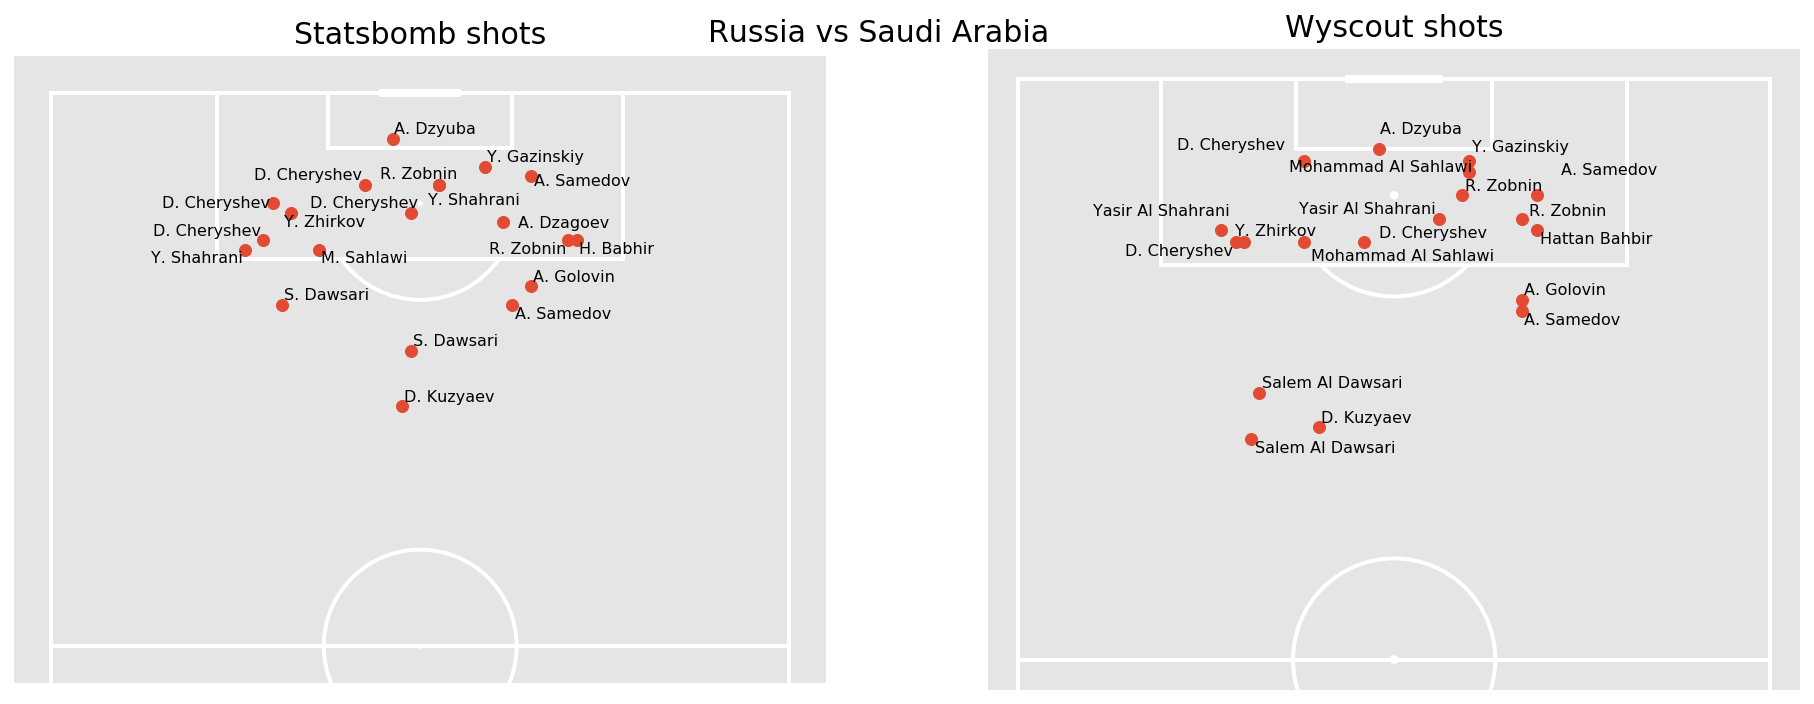

In [13]:
fig, ax  = plt.subplots(1, 2, figsize=(16, 7))
fig.suptitle(f'{team1} vs {team2}', fontsize=15, y=0.85, color='black')
pitch_statsbomb.draw(ax=ax[0])
pitch_statsbomb.scatter(subset_statsbomb.x, subset_statsbomb.y, ax=ax[0])
ax[0].set_title('Statsbomb shots', fontsize=15, color='black')
pitch_wyscout.draw(ax=ax[1])
pitch_statsbomb.scatter(subset_wyscout.start_x, subset_wyscout.start_y, ax=ax[1])
ax[1].set_title('Wyscout shots', fontsize=15, color='black')

# wyscout labels
wyscout_text = []
for i in range(len(subset_wyscout.shortName)):
    text = pitch_wyscout.annotate(subset_wyscout.shortName.iloc[i],
                                  (subset_wyscout.start_x.iloc[i], subset_wyscout.start_y.iloc[i]), fontsize=8,
                                  ax=ax[1], va='center', ha='center', color='black')
    wyscout_text.append(text)
adjust_text(wyscout_text, ax=ax[1])

# statsbomb labels
subset_statsbomb['shortName'] = (subset_statsbomb.player_name.str[0] + 
                                 '. ' + 
                                 subset_statsbomb.player_name.str.split(' ').apply(lambda x: x[-1]))
statsbomb_text = []
for i in range(len(subset_statsbomb.shortName)):
    text = pitch_statsbomb.annotate(subset_statsbomb.shortName.iloc[i],
                                    (subset_statsbomb.x.iloc[i], subset_statsbomb.y.iloc[i]), fontsize=8,
                                    ax=ax[0], va='center', ha='center', color='black')
    statsbomb_text.append(text)
adjust_text(statsbomb_text, ax=ax[0]);
fig.savefig('comparison.png')